# Restaurant Churn Analysis Plan

## Major Assumptions
We assume access to a ChowNow database containing restaurant subscription data with fields for subscription tier, acquisition channel, and churn status/dates. Churn rate will be calculated as the percentage of restaurants that churned within a defined period. We assume sufficient sample sizes exist across tier-channel combinations to produce meaningful segmentation insights. Order data is available to calculate volume and GMV metrics per restaurant.

## Plan
- [x] Query and prepare churn data from ChowNow database
  - [x] Extract restaurant records with subscription tier, acquisition channel, and churn indicators
  - [x] Calculate churn rates for each tier-channel segment combination
- [x] Create polished heatmap visualization of churn by tier and channel
  - [x] Design heatmap with appropriate color scale and annotations for churn percentages
- [x] Analyze order performance metrics by restaurant health status
  - [x] Calculate average order volume and GMV per restaurant from orders table
  - [x] Segment restaurants into thriving vs declining based on performance thresholds
- [x] Synthesize findings on churn drivers and restaurant health indicators

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine

# Connect to ChowNow database
engine = create_engine(os.environ['CHOWNOW_CONNECTION_URL'])

# Query all restaurants to calculate churn by tier and channel
query = """
SELECT 
    subscription_tier,
    acquisition_channel,
    status,
    COUNT(*) as count
FROM public.restaurants
GROUP BY subscription_tier, acquisition_channel, status
ORDER BY subscription_tier, acquisition_channel, status
"""

df_raw = pd.read_sql(query, engine)
engine.dispose()

df_raw

,subscription_tier,acquisition_channel,status,count
0,enterprise,marketplace_convert,active,47
1,enterprise,marketplace_convert,churned,1
2,enterprise,marketplace_convert,paused,2
3,enterprise,partner_referral,active,62
4,enterprise,partner_referral,churned,1
5,enterprise,partner_referral,paused,2
6,enterprise,sales_rep,active,75
7,enterprise,sales_rep,churned,1
8,enterprise,sales_rep,paused,2
9,enterprise,self_serve,active,102


In [2]:
# Calculate churn rate by tier and channel
# Churn = churned / (active + paused + churned)

pivot_df = df_raw.pivot_table(
    index='subscription_tier', 
    columns='acquisition_channel', 
    values='count', 
    aggfunc='sum',
    fill_value=0
)

# Calculate totals and churned counts per segment
totals = df_raw.groupby(['subscription_tier', 'acquisition_channel'])['count'].sum().unstack(fill_value=0)
churned = df_raw[df_raw['status'] == 'churned'].pivot_table(
    index='subscription_tier', 
    columns='acquisition_channel', 
    values='count', 
    aggfunc='sum',
    fill_value=0
)

# Calculate churn rate
churn_rate = (churned / totals * 100).round(2)

# Reorder tiers logically
tier_order = ['starter', 'growth', 'pro', 'enterprise']
churn_rate = churn_rate.reindex(tier_order)

churn_rate

acquisition_channel,marketplace_convert,partner_referral,sales_rep,self_serve
subscription_tier,,,,
starter,4.81,3.65,4.17,5.84
growth,3.57,2.68,3.18,4.45
pro,3.23,2.33,2.06,3.23
enterprise,2.00,1.54,1.28,1.87


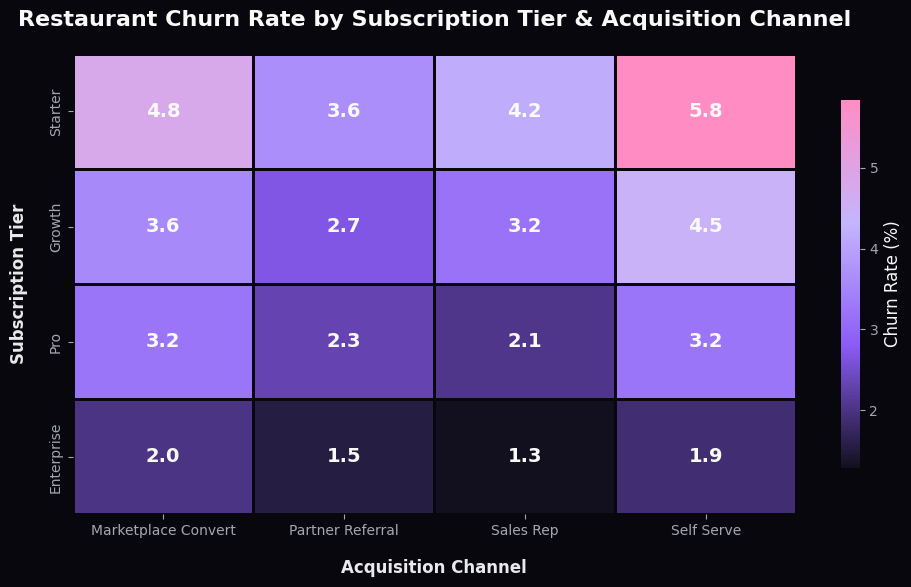

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# SignalPilot dark theme
plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'figure.titlesize': 16, 'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})

# Custom SignalPilot colormap (low=dark, high=pink/red for danger)
sp_cmap = LinearSegmentedColormap.from_list('signalpilot', ['#12101e', '#8b5cf6', '#c4b5fd', '#ff8dc4'])

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 6))

# Format column names for display
display_df = churn_rate.copy()
display_df.columns = [c.replace('_', ' ').title() for c in display_df.columns]
display_df.index = [i.title() for i in display_df.index]

sns.heatmap(display_df, annot=True, fmt='.1f', cmap=sp_cmap, ax=ax,
            annot_kws={'size': 14, 'color': '#FAFAFA', 'weight': 'bold'},
            cbar_kws={'label': 'Churn Rate (%)', 'shrink': 0.8},
            linewidths=2, linecolor='#08070e')

ax.set_xlabel('Acquisition Channel', fontweight='bold', labelpad=15)
ax.set_ylabel('Subscription Tier', fontweight='bold', labelpad=15)
ax.set_title('Restaurant Churn Rate by Subscription Tier & Acquisition Channel', 
             fontweight='bold', pad=20, fontsize=16)

# Style colorbar
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.label.set_color('#FAFAFA')
cbar.ax.tick_params(colors='#a4a7ae')

plt.tight_layout()
plt.show()

In [4]:
# Query order metrics per restaurant with status
query_orders = """
SELECT 
    r.id as restaurant_id,
    r.restaurant_name,
    r.subscription_tier,
    r.status,
    COUNT(o.id) as order_count,
    COALESCE(SUM(o.order_total_usd), 0) as total_gmv,
    COALESCE(AVG(o.order_total_usd), 0) as avg_order_value
FROM public.restaurants r
LEFT JOIN public.orders o ON r.id = o.restaurant_id
GROUP BY r.id, r.restaurant_name, r.subscription_tier, r.status
ORDER BY total_gmv DESC
"""

df_orders = pd.read_sql(query_orders, create_engine(os.environ['CHOWNOW_CONNECTION_URL']))
df_orders

,restaurant_id,restaurant_name,subscription_tier,status,order_count,total_gmv,avg_order_value
0,472,The Ridge Restaurant,enterprise,active,10603,345938.53,32.626476
1,1394,The Sun Kitchen,enterprise,paused,9658,314408.30,32.554183
2,43,Ginger Kitchen,enterprise,active,5396,173823.08,32.213321
3,1990,New Bar & Grill,enterprise,active,5197,170738.32,32.853246
4,649,Stone Sage BBQ,enterprise,active,4798,154935.39,32.291661
...,...,...,...,...,...,...,...
1995,1318,The Lemon Cafe,pro,churned,1,30.19,30.190000
1996,1223,Grand Pines Bakehouse,growth,churned,1,26.29,26.290000
1997,1190,The Star Trattoria,enterprise,churned,1,25.67,25.670000
1998,1549,Happy Pines Trattoria,starter,churned,1,23.50,23.500000


In [5]:
# Classify restaurants as thriving/stable/declining based on order volume percentiles
q75 = df_orders['order_count'].quantile(0.75)
q25 = df_orders['order_count'].quantile(0.25)

df_orders['health_status'] = pd.cut(
    df_orders['order_count'],
    bins=[-1, q25, q75, df_orders['order_count'].max()],
    labels=['Declining', 'Stable', 'Thriving']
)

# Summary stats by health status
health_summary = df_orders.groupby('health_status', observed=True).agg({
    'restaurant_id': 'count',
    'order_count': 'mean',
    'total_gmv': ['mean', 'sum'],
    'avg_order_value': 'mean'
}).round(2)
health_summary.columns = ['Restaurants', 'Avg Orders', 'Avg GMV ($)', 'Total GMV ($)', 'Avg Order Value ($)']
health_summary

,Restaurants,Avg Orders,Avg GMV ($),Total GMV ($),Avg Order Value ($)
health_status,,,,,
Declining,500,162.54,5296.65,2648322.64,32.77
Stable,1000,580.02,18877.79,18877787.86,32.55
Thriving,500,1677.42,54600.02,27300008.26,32.55


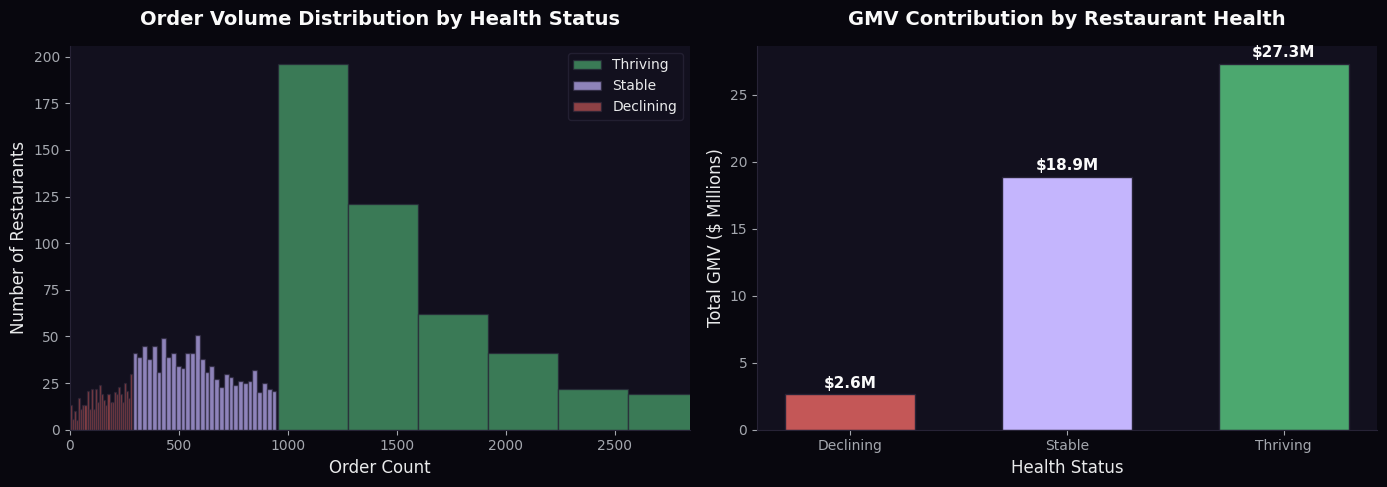


Thresholds: Declining < 289 orders | Stable 289-949 | Thriving > 949 orders


In [6]:
# Visualization: Restaurant Health Distribution with GMV
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Color mapping for health status
health_colors = {'Thriving': '#4ca86f', 'Stable': '#c4b5fd', 'Declining': '#c45757'}

# Left: Order volume distribution by health status
for status in ['Thriving', 'Stable', 'Declining']:
    subset = df_orders[df_orders['health_status'] == status]['order_count']
    axes[0].hist(subset, bins=30, alpha=0.7, label=status, color=health_colors[status], edgecolor='#272336')
axes[0].set_xlabel('Order Count')
axes[0].set_ylabel('Number of Restaurants')
axes[0].set_title('Order Volume Distribution by Health Status', fontweight='bold', pad=15)
axes[0].legend(frameon=True, fancybox=True)
axes[0].set_xlim(0, df_orders['order_count'].quantile(0.98))

# Right: GMV contribution by health status (bar chart)
gmv_by_health = df_orders.groupby('health_status', observed=True)['total_gmv'].sum().reindex(['Declining', 'Stable', 'Thriving'])
bars = axes[1].bar(gmv_by_health.index, gmv_by_health.values / 1e6, 
                   color=[health_colors[s] for s in gmv_by_health.index], width=0.6, edgecolor='#272336')
axes[1].set_xlabel('Health Status')
axes[1].set_ylabel('Total GMV ($ Millions)')
axes[1].set_title('GMV Contribution by Restaurant Health', fontweight='bold', pad=15)

# Add value labels
for bar, val in zip(bars, gmv_by_health.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, val/1e6 + 0.5, 
                f'${val/1e6:.1f}M', ha='center', fontsize=11, fontweight='bold', color='#FAFAFA')

plt.tight_layout()
plt.show()

# Show count breakdown
print(f"\nThresholds: Declining < {q25:.0f} orders | Stable {q25:.0f}-{q75:.0f} | Thriving > {q75:.0f} orders")

In [7]:
# Query subscription tier changes (upgrades vs downgrades)
query_tier_changes = """
SELECT 
    event_type,
    from_tier,
    to_tier,
    reason,
    COUNT(*) as count
FROM public.subscription_history
WHERE event_type IN ('upgrade', 'downgrade')
GROUP BY event_type, from_tier, to_tier, reason
ORDER BY event_type, count DESC
"""

df_tier_changes = pd.read_sql(query_tier_changes, create_engine(os.environ['CHOWNOW_CONNECTION_URL']))
df_tier_changes

,event_type,from_tier,to_tier,reason,count


In [8]:
# Check what event types exist in subscription_history
query_events = """
SELECT event_type, COUNT(*) as count 
FROM public.subscription_history 
GROUP BY event_type
"""
df_events = pd.read_sql(query_events, create_engine(os.environ['CHOWNOW_CONNECTION_URL']))
print("Event types in subscription_history:")
print(df_events)

# Analyze delivery & marketing adoption rates by tier
query_addons = """
SELECT 
    subscription_tier,
    COUNT(*) as total_restaurants,
    SUM(CASE WHEN has_delivery THEN 1 ELSE 0 END) as with_delivery,
    SUM(CASE WHEN has_marketing THEN 1 ELSE 0 END) as with_marketing,
    SUM(CASE WHEN has_delivery AND has_marketing THEN 1 ELSE 0 END) as with_both
FROM public.restaurants
WHERE status = 'active'
GROUP BY subscription_tier
ORDER BY CASE subscription_tier 
    WHEN 'starter' THEN 1 WHEN 'growth' THEN 2 WHEN 'pro' THEN 3 WHEN 'enterprise' THEN 4 
END
"""
df_addons = pd.read_sql(query_addons, create_engine(os.environ['CHOWNOW_CONNECTION_URL']))
df_addons

Event types in subscription_history:
    event_type  count
0    activated   2000
1    cancelled     72
2   downgraded     25
3     upgraded    404
4  reactivated     18
5  plan_change   1035


,subscription_tier,total_restaurants,with_delivery,with_marketing,with_both
0,starter,645,464,276,200
1,growth,564,372,249,162
2,pro,376,270,167,116
3,enterprise,286,185,120,79


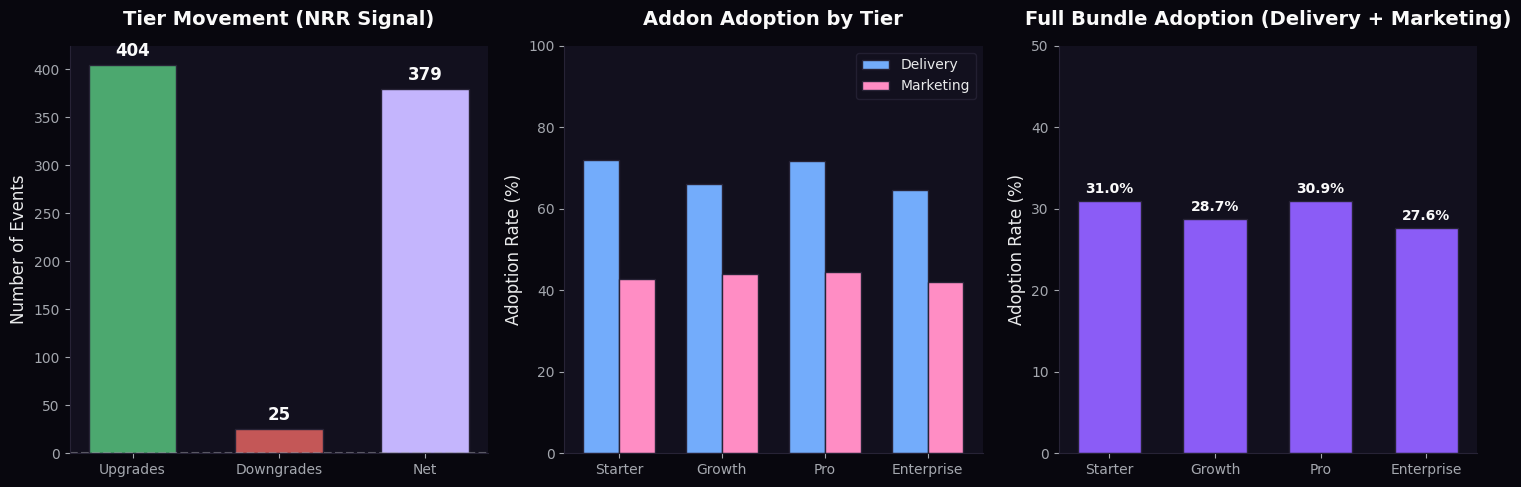


📈 NRR Indicators:
   • Upgrades: 404 | Downgrades: 25 | Net: +379 (16.2x ratio)
   • Overall delivery adoption: 69.0%
   • Overall marketing adoption: 43.4%


In [9]:
# NRR Analysis: Tier upgrades/downgrades and addon adoption

# 1. Upgrade vs downgrade ratio
upgrade_count = df_events[df_events['event_type'] == 'upgraded']['count'].values[0]
downgrade_count = df_events[df_events['event_type'] == 'downgraded']['count'].values[0]
net_upgrades = upgrade_count - downgrade_count

# 2. Calculate addon adoption rates
df_addons['delivery_rate'] = (df_addons['with_delivery'] / df_addons['total_restaurants'] * 100).round(1)
df_addons['marketing_rate'] = (df_addons['with_marketing'] / df_addons['total_restaurants'] * 100).round(1)
df_addons['both_rate'] = (df_addons['with_both'] / df_addons['total_restaurants'] * 100).round(1)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Left: Upgrade/Downgrade flow
events = ['Upgrades', 'Downgrades', 'Net']
values = [upgrade_count, downgrade_count, net_upgrades]
colors = ['#4ca86f', '#c45757', '#c4b5fd']
bars = axes[0].bar(events, values, color=colors, width=0.6, edgecolor='#272336')
axes[0].set_ylabel('Number of Events')
axes[0].set_title('Tier Movement (NRR Signal)', fontweight='bold', pad=15)
axes[0].axhline(y=0, color='#a4a7ae', linestyle='--', alpha=0.5)
for bar, val in zip(bars, values):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 10, f'{val}', ha='center', fontsize=12, fontweight='bold', color='#FAFAFA')

# Middle: Addon adoption rates by tier
x = range(len(df_addons))
width = 0.35
bars1 = axes[1].bar([i - width/2 for i in x], df_addons['delivery_rate'], width, label='Delivery', color='#73acfb', edgecolor='#272336')
bars2 = axes[1].bar([i + width/2 for i in x], df_addons['marketing_rate'], width, label='Marketing', color='#ff8dc4', edgecolor='#272336')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Starter', 'Growth', 'Pro', 'Enterprise'])
axes[1].set_ylabel('Adoption Rate (%)')
axes[1].set_title('Addon Adoption by Tier', fontweight='bold', pad=15)
axes[1].legend(frameon=True, fancybox=True)
axes[1].set_ylim(0, 100)

# Right: Both addons adoption (expansion potential)
bars3 = axes[2].bar(df_addons['subscription_tier'].str.title(), df_addons['both_rate'], color='#8b5cf6', width=0.6, edgecolor='#272336')
axes[2].set_ylabel('Adoption Rate (%)')
axes[2].set_title('Full Bundle Adoption (Delivery + Marketing)', fontweight='bold', pad=15)
axes[2].set_ylim(0, 50)
for bar, val in zip(bars3, df_addons['both_rate']):
    axes[2].text(bar.get_x() + bar.get_width()/2, val + 1, f'{val}%', ha='center', fontsize=10, fontweight='bold', color='#FAFAFA')

plt.tight_layout()
plt.show()

# Summary table
print(f"\n📈 NRR Indicators:")
print(f"   • Upgrades: {upgrade_count} | Downgrades: {downgrade_count} | Net: +{net_upgrades} ({upgrade_count/downgrade_count:.1f}x ratio)")
print(f"   • Overall delivery adoption: {df_addons['with_delivery'].sum()/df_addons['total_restaurants'].sum()*100:.1f}%")
print(f"   • Overall marketing adoption: {df_addons['with_marketing'].sum()/df_addons['total_restaurants'].sum()*100:.1f}%")

In [10]:
# Query marketplace comparison data for commission savings analysis
query_commission = """
SELECT 
    r.subscription_tier,
    r.status,
    mc.estimated_marketplace_gmv_usd,
    mc.estimated_commission_rate,
    mc.estimated_monthly_commission_usd
FROM public.marketplace_comparison mc
JOIN public.restaurants r ON mc.restaurant_id = r.id
WHERE r.status = 'active'
"""

df_commission = pd.read_sql(query_commission, create_engine(os.environ['CHOWNOW_CONNECTION_URL']))
df_commission.head(10)

,subscription_tier,status,estimated_marketplace_gmv_usd,estimated_commission_rate,estimated_monthly_commission_usd
0,pro,active,1404.43,0.2552,358.41
1,enterprise,active,1389.77,0.2913,404.84
2,starter,active,287.68,0.2994,86.13
3,starter,active,1287.00,0.3000,386.10
4,enterprise,active,4178.99,0.2503,1046.00
5,growth,active,1650.10,0.3000,495.03
6,enterprise,active,2699.04,0.2914,786.50
7,starter,active,2636.46,0.2932,773.01
8,starter,active,1116.47,0.2787,311.16
9,pro,active,3037.00,0.2662,808.45


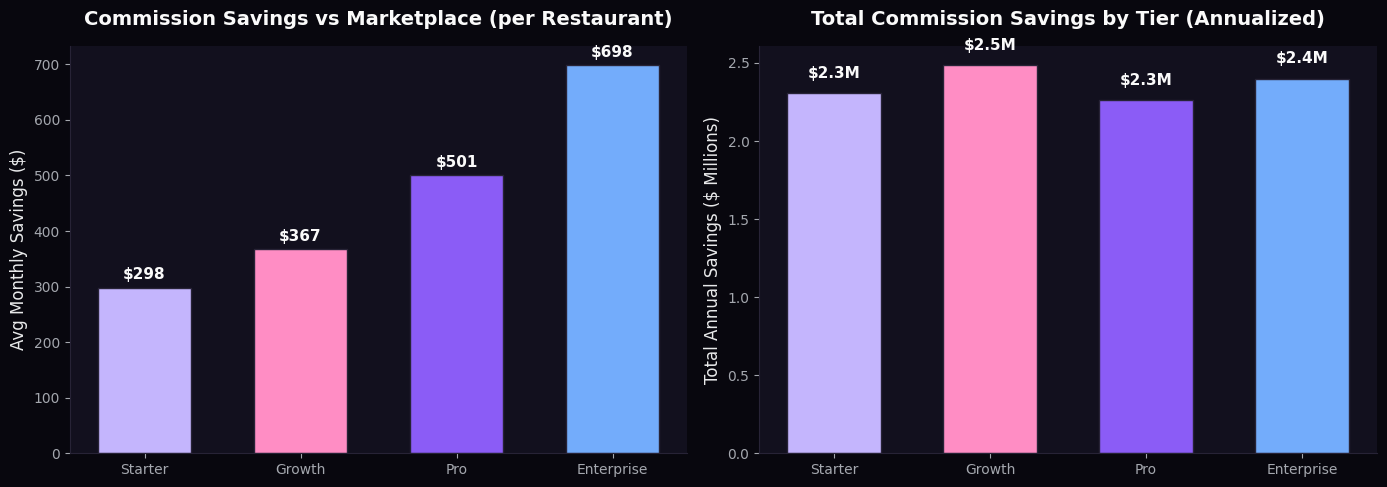


💰 Commission Savings Summary:
   • Avg marketplace commission rate: 28.5%
   • Avg monthly savings per restaurant: $421
   • Total monthly savings (all restaurants): $787,322
   • Total annual savings: $9.4M


In [12]:
# Commission savings analysis: ChowNow vs DoorDash/UberEats
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Calculate savings per restaurant
tier_order = ['starter', 'growth', 'pro', 'enterprise']
savings_by_tier = df_commission.groupby('subscription_tier').agg({
    'estimated_marketplace_gmv_usd': 'mean',
    'estimated_commission_rate': 'mean',
    'estimated_monthly_commission_usd': ['mean', 'sum', 'count']
}).round(2)
savings_by_tier.columns = ['Avg GMV ($)', 'Avg Commission Rate', 'Avg Monthly Savings ($)', 'Total Monthly Savings ($)', 'Restaurants']
savings_by_tier = savings_by_tier.reindex(tier_order)

# Annualize savings
savings_by_tier['Annual Savings ($)'] = (savings_by_tier['Total Monthly Savings ($)'] * 12).round(0)
savings_by_tier['Avg Annual Savings ($)'] = (savings_by_tier['Avg Monthly Savings ($)'] * 12).round(0)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Average monthly savings per restaurant by tier
tiers = ['Starter', 'Growth', 'Pro', 'Enterprise']
avg_savings = savings_by_tier['Avg Monthly Savings ($)'].values
bars = axes[0].bar(tiers, avg_savings, color=CATEGORICAL_PALETTE[:4], width=0.6, edgecolor='#272336')
axes[0].set_ylabel('Avg Monthly Savings ($)')
axes[0].set_title('Commission Savings vs Marketplace (per Restaurant)', fontweight='bold', pad=15)
for bar, val in zip(bars, avg_savings):
    axes[0].text(bar.get_x() + bar.get_width()/2, val + 15, f'${val:,.0f}', ha='center', fontsize=11, fontweight='bold', color='#FAFAFA')

# Right: Total annual savings across all restaurants by tier
annual_total = savings_by_tier['Annual Savings ($)'].values / 1e6
bars2 = axes[1].bar(tiers, annual_total, color=CATEGORICAL_PALETTE[:4], width=0.6, edgecolor='#272336')
axes[1].set_ylabel('Total Annual Savings ($ Millions)')
axes[1].set_title('Total Commission Savings by Tier (Annualized)', fontweight='bold', pad=15)
for bar, val in zip(bars2, annual_total):
    axes[1].text(bar.get_x() + bar.get_width()/2, val + 0.1, f'${val:.1f}M', ha='center', fontsize=11, fontweight='bold', color='#FAFAFA')

plt.tight_layout()
plt.show()

# Summary stats
total_monthly = df_commission['estimated_monthly_commission_usd'].sum()
total_annual = total_monthly * 12
avg_rate = df_commission['estimated_commission_rate'].mean() * 100

print(f"\n💰 Commission Savings Summary:")
print(f"   • Avg marketplace commission rate: {avg_rate:.1f}%")
print(f"   • Avg monthly savings per restaurant: ${df_commission['estimated_monthly_commission_usd'].mean():,.0f}")
print(f"   • Total monthly savings (all restaurants): ${total_monthly:,.0f}")
print(f"   • Total annual savings: ${total_annual/1e6:.1f}M")